# Load in the packages

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm

plus_minus = u"\u00B1"

# Load in the data files

In [10]:
# load in sample names from the folder names in the directory
path = os.getcwd()
sample_names = natsorted([n for n in os.listdir() if '.' not in n])

# load in the power reference and index by the currents rounded to the first decimal place
ref = pd.read_csv('PowerCurrent_Averaged.csv', index_col='currents')
ref.index = np.round(ref.index, decimals = 1)

# load in the SQ limit dataframe
sq = pd.read_csv('SQ.csv', index_col='Eg')

fids = {}
for n in sample_names:
    s_path = os.path.join(path, n)
    fids[n] = natsorted([os.path.join(s_path, f) for f in os.listdir(s_path) if '.csv' in f])

currents = {}
data = {}
for n in sample_names:
    currents[n] = [np.round(float(f.split("_")[-1][:-4]), decimals=1) for f in fids[n]]
    data[n] = {}
    data[n]['powers'] = np.array(ref['power'][currents[n]])*1000 #watts to mW

# Define the functions for analysis

In [11]:
def load_plqy(fid):

    """Simple function to load .csv plqy data

    Args:
        fid (str): file path, should be .csv

    Returns:
        pd.DataFrame: a data frame containing the six scan types necessary to calculate PLQY
    """

    df = pd.read_csv(fid)
    
    return df
    
def calc_plqy_deMello(data: pd.DataFrame, sample_wl: float, sample_resp: float, laser_wl: float, laser_resp: float):

    """A function to calculate the PLQY based in a publication by de Mello et al.
       The most widely used method for calculating PLQY.
       https://doi.org/10.1002/adma.19970090308

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
        sample_wl (float): the peak emission wavelength of the sample
        sample_resp (float): the responsivity of the detector at sample_wl
        laser_wl (float): the emission wavelength of the laser. Probably 532.0nm
        laser_resp (float): the responsivity of the detector at the laser_wl

    Returns:
        tuple: (PLQY, PLQY error), resported as fractional, not percentage
    """

    E_in = data['in_lp'].mean()
    E_in_err = data['in_lp'].std()/E_in

    E_out = data['out_lp'].mean()
    E_out_err = data['out_lp'].std()/E_out

    X_in = data['in_nolp'].mean() - E_in
    X_in_err = (data['in_nolp'].std()/X_in) + E_in_err

    X_out = data['out_nolp'].mean() - E_out
    X_out_err = (data['out_nolp'].std()/X_out) + E_out_err

    X_empty = data['empty_nolp'].mean() - data['empty_lp'].mean()
    X_empty_err = (data['empty_nolp'].std()/data['empty_nolp'].mean()) + (data['empty_lp'].std()/data['empty_lp'].mean())

    E_in = E_in*(sample_wl/sample_resp)
    E_out = E_out*(sample_wl/sample_resp)

    X_in = X_in*(laser_wl/laser_resp)
    X_out = X_out*(laser_wl/laser_resp)
    X_empty = X_empty*(laser_wl/laser_resp)

    a = (X_out-X_in)/X_out
    a_err = np.sqrt(((X_out_err + X_in_err)**2) + (X_out_err**2))

    plqy = (E_in-(1-a)*E_out)/(X_empty*a)
    plqy_err = np.sqrt((E_in_err**2) + ((E_out_err + a_err)**2) + (X_empty_err**2))

    return plqy, plqy_err*plqy

def plot_signals(data: pd.DataFrame):

    """Janky plots of the individual signals over the course of the measurement.
       Could be useful to have a quick look at what might be throwing off your measurement

    Args:
        data (pd.DataFrame): dataframe loaded in using the load_plqy() function
    """

    fig, axs = plt.subplots(3,2, figsize = (8,6), dpi = 300)
    axs = axs.flatten()
    for i,col in enumerate(data.columns):
        axs[i].plot(data[col], label = col)
        axs[i].set_xticks([])
        axs[i].set_title(col)
        axs[i].ticklabel_format(axis='both', style='scientific', scilimits=(0,0))
        
    plt.tight_layout()

def get_responsivity(emission_wl):
    """internal function to get the respnsivity of the detector at the emission wavelength

    Args:
        emission_wl (float): the mean emission wavelength of the sample

    Returns:
        float: the responsivity, arbitrary units
    """
    try:
        resp = pd.read_csv('Detector_Responsivity.csv')


        return float(resp['Responsivity'][resp['Wavelength'] == emission_wl])

    except: # if not, tell the user to do so
        print(f'Detector_Responsivity.csv not able to load...check code')

# Calculate PLQY

In [12]:
EMISSION_WL = 808
LASER_WL = 532
LASER_SPOT_SIZE = 0.066 #cm2
kT = 0.026 #eV
REFLECTION_LOSSES = 0.17 # fraction of 1 taken off of the Jsc to make implied curve more real

EMISSION_RESP = get_responsivity(EMISSION_WL)
LASER_RESP = get_responsivity(LASER_WL)

In [13]:
for n in sample_names:
    temp_plqys = []
    temp_errs = []
    
    for fid in tqdm(fids[n]):

        deMello = calc_plqy_deMello(load_plqy(fid), EMISSION_WL, EMISSION_RESP, LASER_WL, LASER_RESP)
        temp_plqys.append(deMello[0])
        temp_errs.append(deMello[1])
    
    data[n]['plqy'] = np.array(temp_plqys)
    data[n]['plqy_err'] = np.array(temp_errs)
    data[n]['Eg'] = np.round(1240/EMISSION_WL, decimals=2)
    data[n]['Voc_rad'] = sq['Voc'][data[n]['Eg']]
    data[n]['Jsc_rad'] = sq['Jsc'][data[n]['Eg']]
    data[n]['Suns'] = (data[n]['powers']/LASER_SPOT_SIZE)/sq['laser power'][data[n]['Eg']]

    data[n]['qfls'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns']*data[n]['plqy'])
    data[n]['qfls_err'] = np.log(1 + data[n]['plqy_err']/data[n]['plqy'])
    data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns'])

    data[n]['implied_current'] = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-data[n]['Suns'])
    data[n]['implied_current_limit'] = data[n]['Jsc_rad']*(1-data[n]['Suns'])
    

100%|██████████| 24/24 [00:00<00:00, 468.10it/s]


# Log Plot of Irradiance vs. PLQY

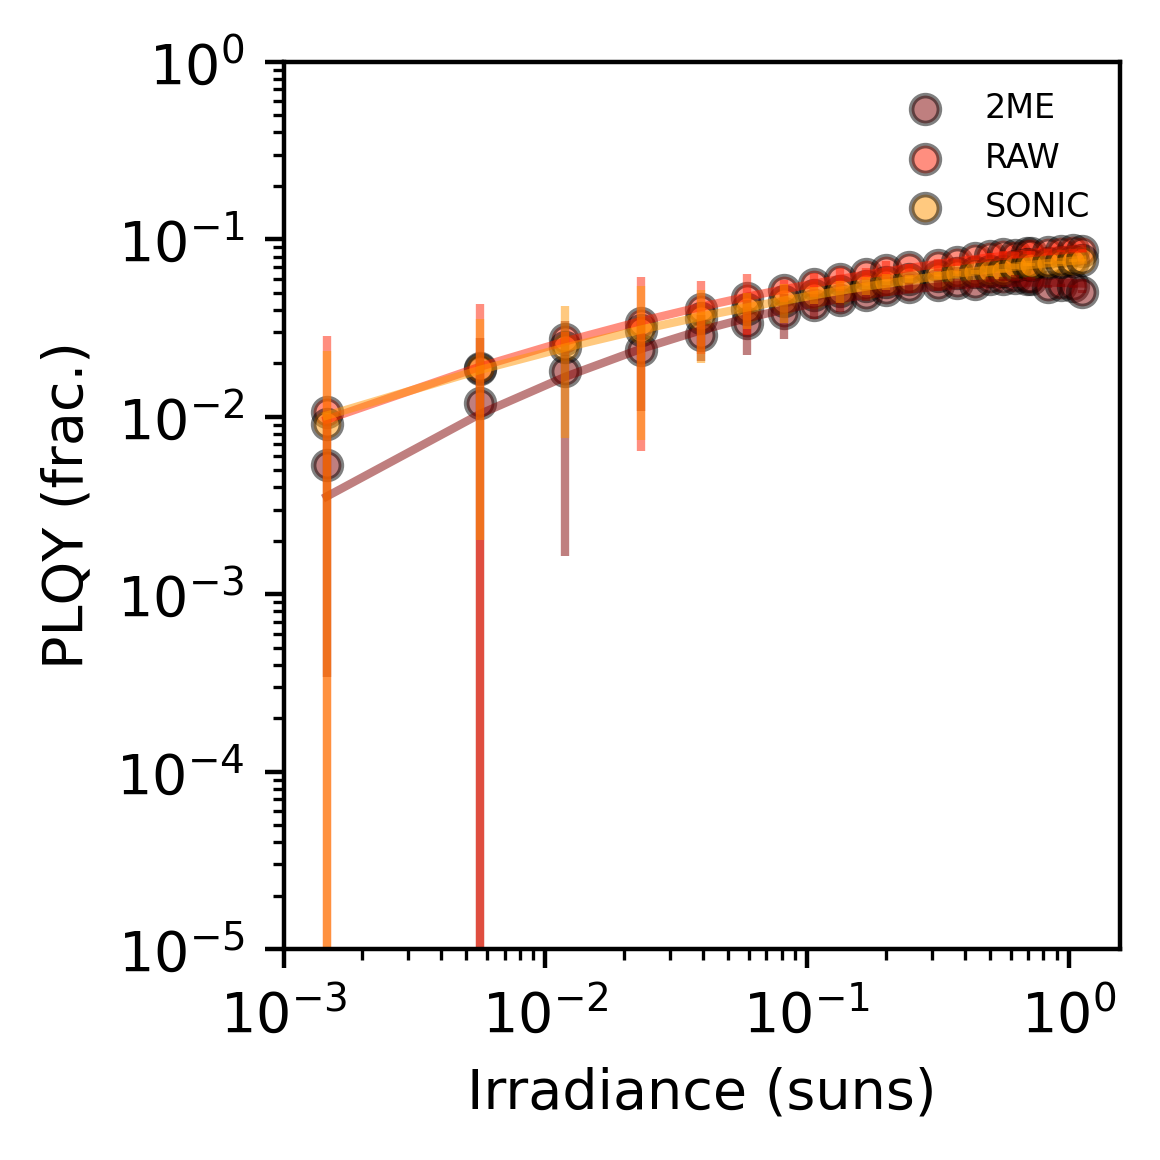

In [14]:
fig, axs = plt.subplots(1,1,figsize = (3,3), dpi = 400)

colors = plt.cm.jet(np.linspace(0,1,9))[::-1]

for i,n in enumerate(sample_names):

    x = data[n]['Suns']
    y = data[n]['plqy']
    y_error = data[n]['plqy_err']

    axs.scatter(x,y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label = n.replace('_', ', ').replace('0p', '0.'))
    axs.errorbar(x, y, yerr = y_error, color = colors[i], alpha = 0.5, fmt='none')

    if len(x) > 0:   
        x_fit = np.log(x)[2:]
        y_fit = np.log(y)[2:]
        a,b,c = np.polyfit(x_fit, y_fit, 2)
        axs.plot(x, np.exp(a*np.log(x)*np.log(x) + b*np.log(x) + c), linestyle = 'solid', alpha = 0.5, color = colors[i])

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylabel('PLQY (frac.)')
axs.set_ylim(top = 1e0, bottom = 1e-5)
axs.set_xlim(1e-3,)
axs.set_xlabel('Irradiance (suns)')
axs.legend(fontsize = 6, frameon = False)

plt.tight_layout()

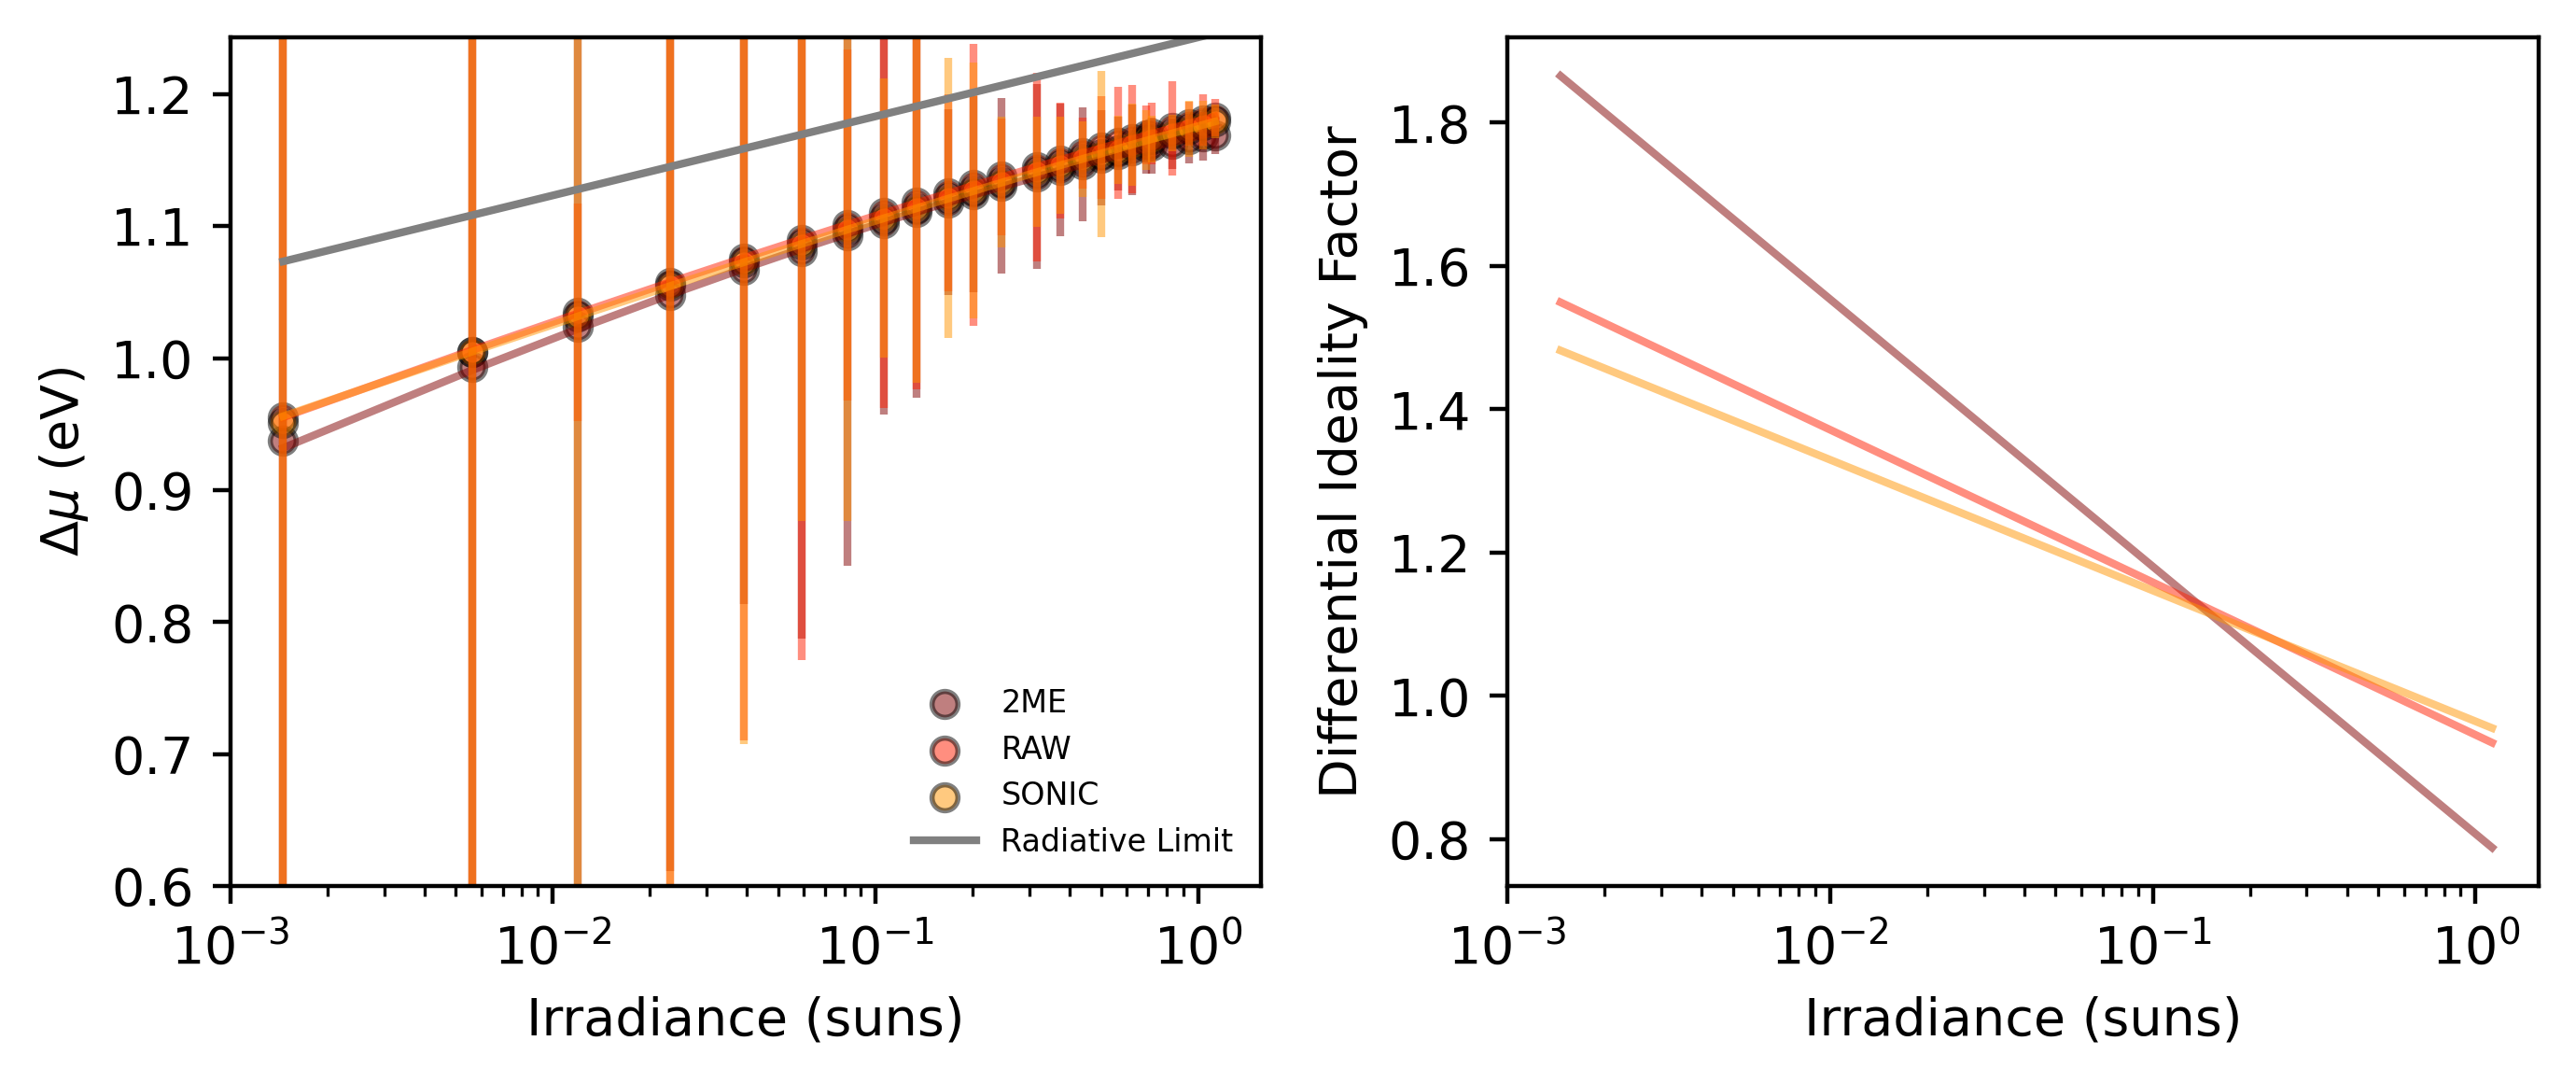

In [15]:
fig, axs = plt.subplots(1,2,figsize = (7,3), dpi = 400)

colors = plt.cm.jet(np.linspace(0,1,9))[::-1]

for i,n in enumerate(sample_names):

    x = data[n]['Suns']
    y = data[n]['qfls']
    y_error = data[n]['qfls_err']
    axs[0].scatter(x,y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label = n.replace('_', ', ').replace('0p', '0.'))
    axs[0].errorbar(x, y, yerr = y_error, color = colors[i], alpha = 0.5, fmt='none')

    if len(x) > 0:   
        x_fit = np.log(x)[2:]
        y_fit = np.log(y)[2:]
        a,b,c = np.polyfit(x_fit, y_fit, 2)
        
        best_fit = np.exp(a*np.log(x)*np.log(x) + b*np.log(x) + c)
        
        dydx = (2*a*np.log(x) + b)/0.0259
        
        data[n]['fit_params'] = np.array([a,b,c])
        data[n]['best_fit'] = best_fit
        data[n]['dydx_fit'] = dydx
        
        axs[0].plot(x, best_fit, linestyle = 'solid', alpha = 0.5, color = colors[i])
        
        axs[1].plot(x, dydx, linestyle = 'solid', alpha = 0.5, color = colors[i])

axs[0].plot(x, data[n]['qfls_rad'], label = 'Radiative Limit', color = 'gray')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_ylabel(r'$\Delta\mu$ (eV)')
axs[1].set_ylabel('Differential Ideality Factor')

axs[0].set_ylim(bottom = 0.6, top = data[n]['Voc_rad'])
# axs[1].set_ylim(bottom = 1)

axs[0].set_xlim(1e-3,)
axs[1].set_xlim(1e-3,)

axs[0].set_xlabel('Irradiance (suns)')
axs[1].set_xlabel('Irradiance (suns)')

axs[0].legend(fontsize = 6, frameon = False, loc = 'lower right')

plt.tight_layout()

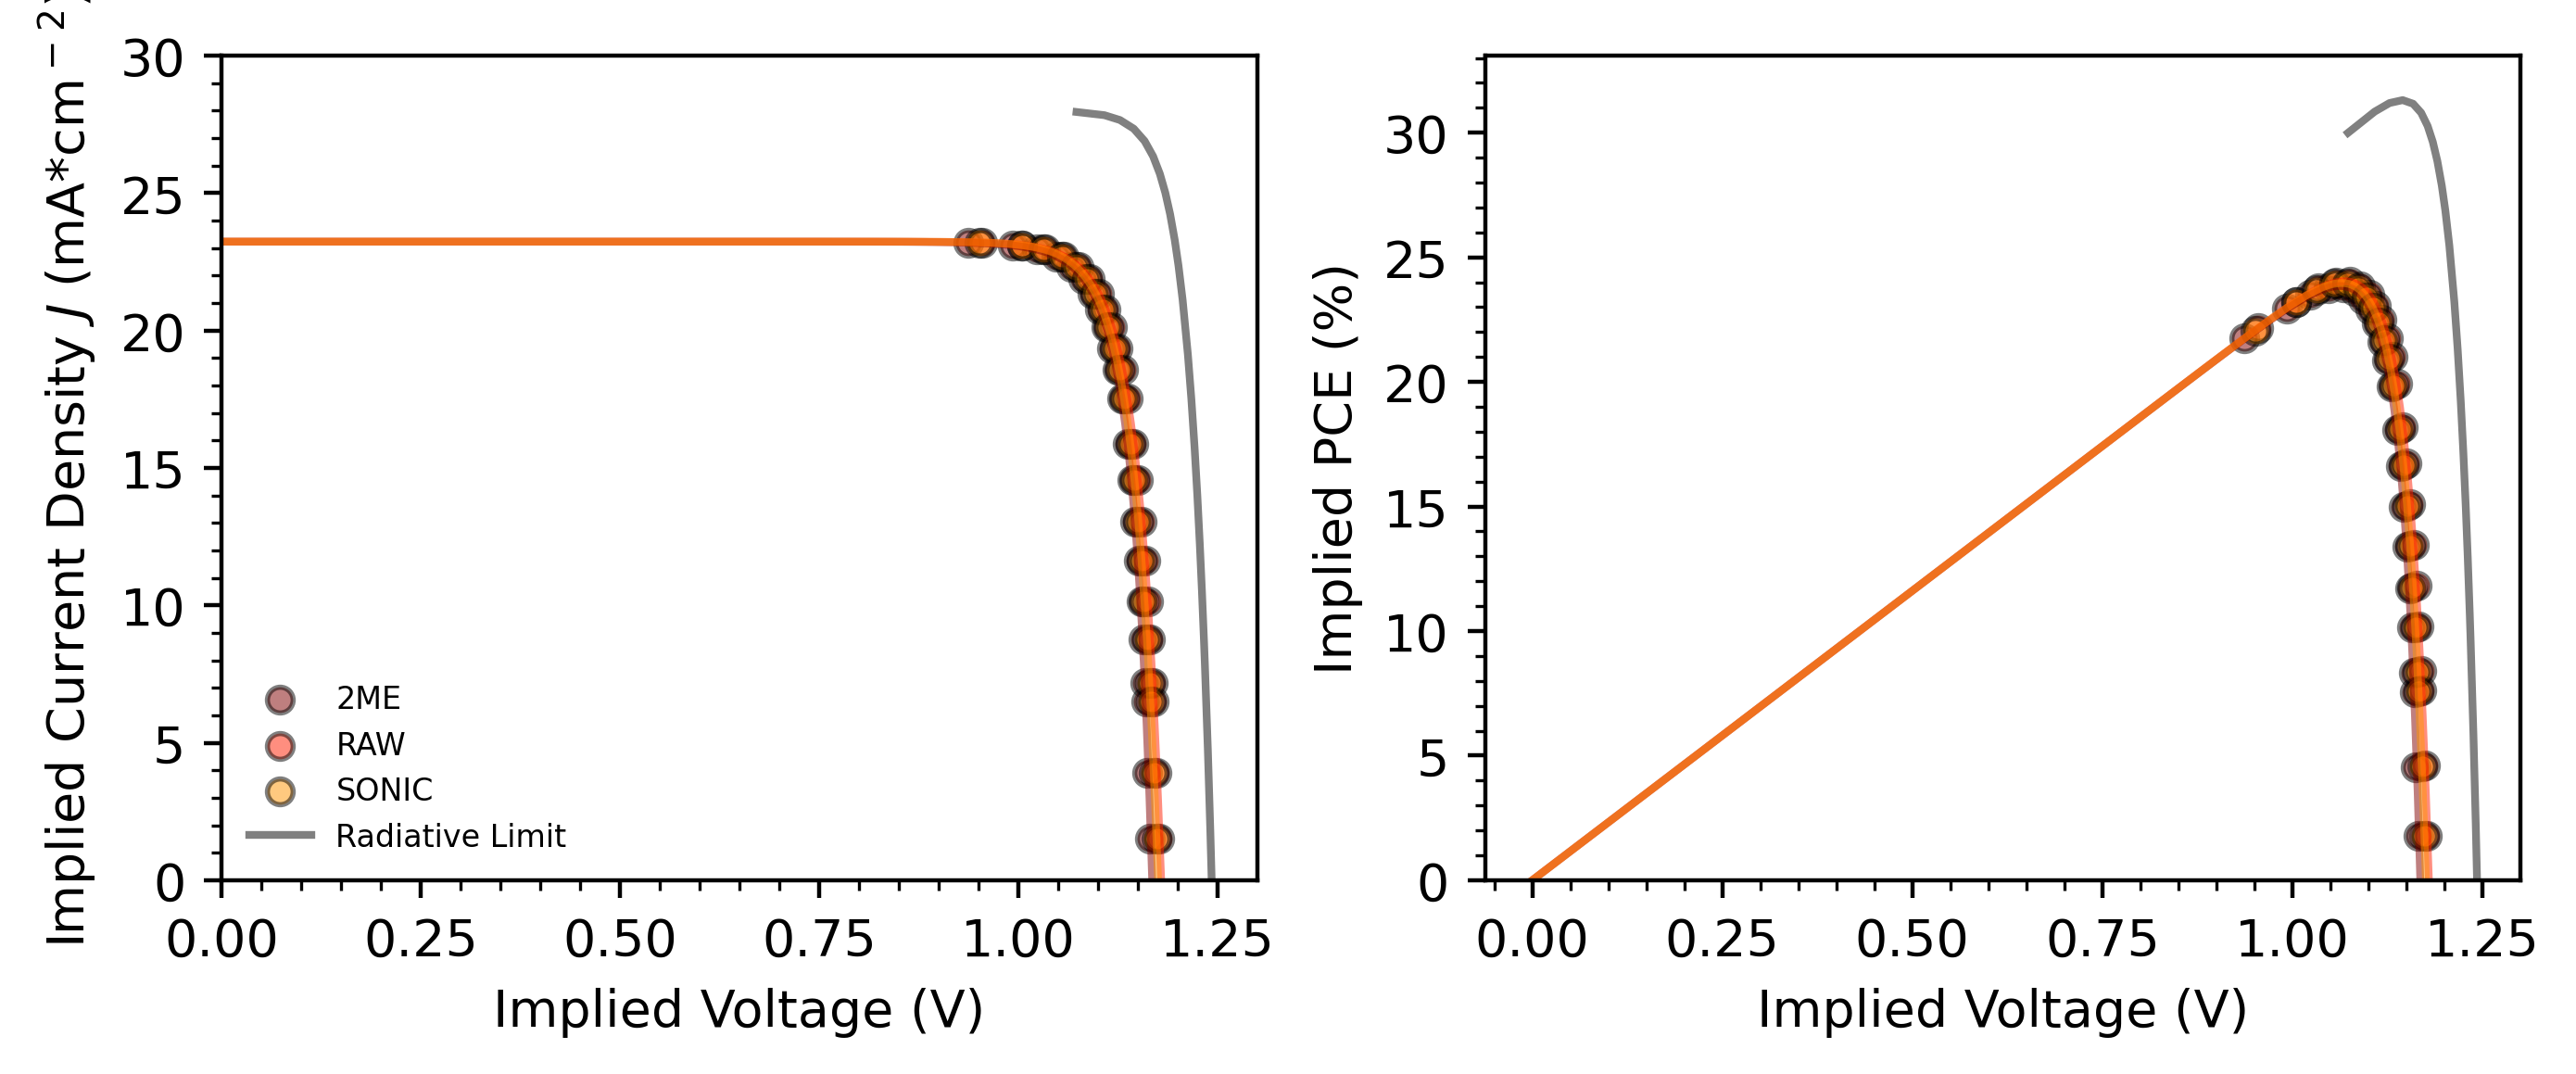

In [17]:
fig, axs = plt.subplots(1,2,figsize = (7,3), dpi = 400)

colors = plt.cm.jet(np.linspace(0,1,9))[::-1]

for i,n in enumerate(sample_names):

    x = data[n]['qfls']
    x_error = data[n]['qfls_err']
    x_fit = data[n]['best_fit']
    y = data[n]['implied_current']
    axs[0].scatter(x,y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label = n.replace('_', ', ').replace('0p', '0.'))
    axs[1].scatter(x, x*y,facecolor = colors[i], alpha = 0.5, edgecolors = 'black', s = 25, label = n.replace('_', ', ').replace('0p', '0.'))  

    a,b,c = data[n]['fit_params']
    suns_fit = np.logspace(-6,0, num=100)
    x_fit = np.exp(a*np.log(suns_fit)*np.log(suns_fit) + b*np.log(suns_fit) + c)
    implied_current_fit = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-suns_fit)
    implied_current_fit = np.insert(implied_current_fit, 0, data[n]['Jsc_rad']*(1-REFLECTION_LOSSES))
    x_fit = np.insert(x_fit, 0, 0)
    
    axs[0].plot(x_fit,implied_current_fit, color = colors[i], alpha = 0.5)
    axs[1].plot(x_fit,implied_current_fit*x_fit, color = colors[i], alpha = 0.5)
    

    

axs[0].plot(data[n]['qfls_rad'], data[n]['implied_current_limit'] , label = 'Radiative Limit', color = 'gray')
axs[1].plot(data[n]['qfls_rad'], data[n]['implied_current_limit']*data[n]['qfls_rad'] , label = 'Radiative Limit', color = 'gray')

axs[0].set_xlabel('Implied Voltage (V)')
axs[0].set_ylabel('Implied Current Density $J$ (mA*cm$^-$$^2$)')

axs[1].set_xlabel('Implied Voltage (V)')
axs[1].set_ylabel('Implied PCE (%)')

axs[0].set_ylim(bottom = 0, top = 30)
axs[0].set_xlim(left = 0, right = np.ceil(10*data[n]['Voc_rad'])/10)

axs[1].set_ylim(bottom = 0,)
axs[1].set_xlim(right = np.ceil(10*data[n]['Voc_rad'])/10)

axs[0].legend(fontsize = 6, frameon = False, loc = 'lower left')

axs[0].minorticks_on()
axs[1].minorticks_on()

plt.tight_layout()